# TP3

In [315]:
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import welch
import scipy as sp
import pandas as pd
import seaborn
import numpy as np
from matplotlib.colors import LogNorm
import math
import itertools
import sklearn.metrics
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

%matplotlib inline

Samples = 201
Duration = 0.8

DELTA = (0,4)
THETA = (4,8)
ALPHA = (8,13)
BETA = (13,30)
GAMMA = (30,45) 

electrodes = [4,12,13,14,19,20,21,22,25,26,27,28,29,31,32,33,34,35]

In [35]:
cant_electrodes = len(electrodes)
cant_electrodes

18

### sujetos

In [36]:
SUJETOS_P = ["/Users/lmatayoshi/Desktop/EEG/P" + str(0) + str(i) + ".mat" for i in range(1,10)]
SUJETOS_P.append("/Users/lmatayoshi/Desktop/EEG/P10.mat")

SUJETOS_S = ["/Users/lmatayoshi/Desktop/EEG/S" + str(0) + str(i) + ".mat" for i in range(1,10)]
SUJETOS_S.append("/Users/lmatayoshi/Desktop/EEG/S10.mat")

In [37]:
def banda_frecuencia_groups(electrodes):
    frecuencias_mean_S = []
    frecuencias_mean_P = []
    frecuencias_std_P = []
    frecuencias_std_S = []
    for sujeto_S in SUJETOS_S:
        bandas_df_mean,bandas_df_sd = bandas_frecuencia_sujeto(sujeto_S,electrodes)
        frecuencias_mean_S.append(bandas_df_mean)
        frecuencias_std_S.append(bandas_df_sd)
    for sujeto_P in SUJETOS_P:
        bandas_df_mean,bandas_df_sd = bandas_frecuencia_sujeto(sujeto_P,electrodes)
        frecuencias_mean_P.append(bandas_df_mean)
        frecuencias_std_P.append(bandas_df_sd)    
    return frecuencias_mean_S, frecuencias_std_S, frecuencias_mean_P, frecuencias_std_P

def bandas_frecuencia_sujeto(sujeto,electrodes): 
    """
    Esta función se realizo para gráficar las bandas de frecuencia para un solo sujeto (con fines de economizar tiempo)
    En caso de de ser necesario puede agrandarse a varios sujetos,  ver 2.e 
    """
    
    sujeto_matrix = sio.loadmat(sujeto)
    sujeto_matrix = sujeto_matrix['data']
    mean_electrodos = np.mean(sujeto_matrix[:,electrodes,:], axis=1) # Promedio de todos los electrodos
    
    f, Pxx = welch(mean_electrodos, float(Samples/Duration), nfft=1025) # Realizo un welch por epoca

    xs = []
    for i in [DELTA[1],THETA[1],ALPHA[1],BETA[1],GAMMA[1]]:
        for j in range(0,len(f)):
            if(f[j]>i):
                xs.append(j);
                break;
    #·hicimos la banda de frecuencia promedidada por cada epoch
    
    epochs_x_banda=np.zeros((Pxx.shape[0], 5))
    for epoch in range(0, Pxx.shape[0]):
        delta_epoch = np.mean(Pxx[epoch][0:xs[0]])
        theta_epoch = np.mean(Pxx[epoch][xs[0]:xs[1]])
        alpha_epoch = np.mean(Pxx[epoch][xs[1]:xs[2]])
        beta_epoch = np.mean(Pxx[epoch][xs[2]:xs[3]])
        gamma_epoch = np.mean(Pxx[epoch][xs[3]:])
        epochs_x_banda[epoch] = np.array([delta_epoch, theta_epoch, alpha_epoch, beta_epoch, gamma_epoch])
                
    todas = np.mean(epochs_x_banda, axis=0)
    todis = np.std(epochs_x_banda, axis=0)

    
    #print todas.shape
    
    
    #electrodes_power_mean = np.mean(Pxx, axis=0) # Se promedian las potencias de todas las epocas, se obtiene
                                                 # de esta manera, un valor de potencia promedio para cada frec
    
    
    bandas_df_mean = pd.DataFrame(todas, index=["Delta", "Theta", "Alpha", "Beta", "Gamma"])
    bandas_df_sd = pd.DataFrame (todis, index=["Delta_SD", "Theta_SD", "Alpha_SD", "Beta_SD", "Gamma_SD"])
    #bandas_power = ([Delta, Theta, Alpha, Beta, Gamma],[Delta_SD, Theta_SD, Alpha_SD, Beta_SD, Gamma_SD])
    return todas,todis

In [38]:
frecuencias_mean_S, frecuencias_std_S, frecuencias_mean_P, frecuencias_std_P = banda_frecuencia_groups(electrodes)

/usr/local/lib/python2.7/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 201, using nperseg = 201
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


<function matplotlib.pyplot.show>

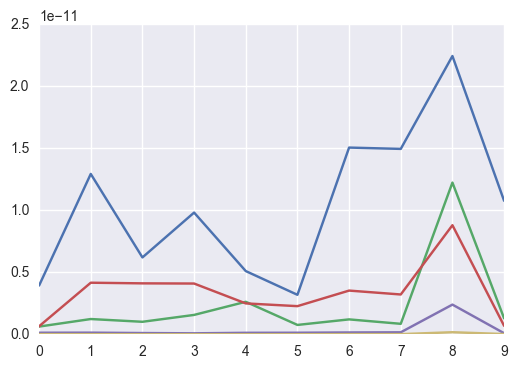

In [39]:
plt.plot(frecuencias_std_S)
plt.show

# Normalizacion

In [40]:
def bandas_normalizadas_groups(electrodes):
    frecuencias_mean_S = []
    frecuencias_mean_P = []
    frecuencias_std_P = []
    frecuencias_std_S = []
    for sujeto_S in SUJETOS_S:
        bandas_df_mean,bandas_df_sd = bandas_frecuencia_normalizadas_sujeto(sujeto_S,electrodes)
        frecuencias_mean_S.append(bandas_df_mean)
        frecuencias_std_S.append(bandas_df_sd)
    for sujeto_P in SUJETOS_P:
        bandas_df_mean,bandas_df_sd = bandas_frecuencia_normalizadas_sujeto(sujeto_P,electrodes)
        frecuencias_mean_P.append(bandas_df_mean)
        frecuencias_std_P.append(bandas_df_sd)    
    return frecuencias_mean_S, frecuencias_std_S, frecuencias_mean_P, frecuencias_std_P

def bandas_frecuencia_normalizadas_sujeto(sujeto,electrodes): 
    """
    Esta función se realizo para gráficar las bandas de frecuencia para un solo sujeto (con fines de economizar tiempo)
    En caso de de ser necesario puede agrandarse a varios sujetos,  ver 2.e 
    """
    
    sujeto_matrix = sio.loadmat(sujeto)
    sujeto_matrix = sujeto_matrix['data']
    mean_electrodos = np.mean(sujeto_matrix[:,electrodes,:], axis=1) # Promedio de todos los electrodos
    
    f, Pxx = welch(mean_electrodos, float(Samples/Duration), nfft=1025) # Realizo un welch por epoca

    xs = []
    for i in [DELTA[1],THETA[1],ALPHA[1],BETA[1],GAMMA[1]]:
        for j in range(0,len(f)):
            if(f[j]>i):
                xs.append(j);
                break;
    #·hicimos la banda de frecuencia promedidada por cada epoch
    
    
    epochs_x_banda=np.zeros((Pxx.shape[0], 5))
    for epoch in range(0, Pxx.shape[0]):
        valor_de_normalizacion = 1/sum(Pxx[epoch][0:GAMMA[1]])

        delta_epoch = np.mean(Pxx[epoch][0:xs[0]])*valor_de_normalizacion
        theta_epoch = np.mean(Pxx[epoch][xs[0]:xs[1]])*valor_de_normalizacion
        alpha_epoch = np.mean(Pxx[epoch][xs[1]:xs[2]])*valor_de_normalizacion
        beta_epoch = np.mean(Pxx[epoch][xs[2]:xs[3]])*valor_de_normalizacion
        gamma_epoch = np.mean(Pxx[epoch][xs[3]:])*valor_de_normalizacion
        
        epochs_x_banda[epoch] = np.array([delta_epoch, theta_epoch, alpha_epoch, beta_epoch, gamma_epoch])
                
    todas = np.mean(epochs_x_banda, axis=0)
    todis = np.std(epochs_x_banda, axis=0)

    
    #print todas.shape
    
    
    #electrodes_power_mean = np.mean(Pxx, axis=0) # Se promedian las potencias de todas las epocas, se obtiene
                                                 # de esta manera, un valor de potencia promedio para cada frec
    
    
    bandas_df_mean = pd.DataFrame(todas, index=["Delta", "Theta", "Alpha", "Beta", "Gamma"])
    bandas_df_sd = pd.DataFrame (todis, index=["Delta_SD", "Theta_SD", "Alpha_SD", "Beta_SD", "Gamma_SD"])
    #bandas_power = ([Delta, Theta, Alpha, Beta, Gamma],[Delta_SD, Theta_SD, Alpha_SD, Beta_SD, Gamma_SD])
    return todas,todis

In [41]:
frecuencias_mean_S_normalizadas, frecuencias_std_S_normalizadas, frecuencias_mean_P_normalizadas, frecuencias_std_P_normalizadas = bandas_normalizadas_groups(electrodes)

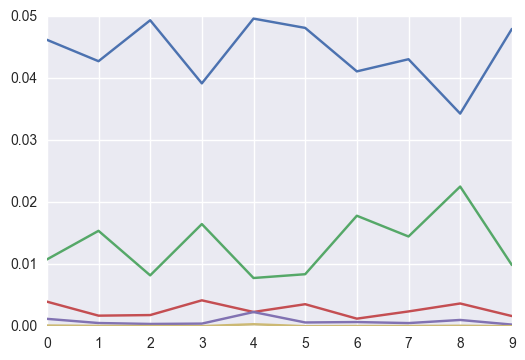

In [229]:
#plt.plot(frecuencias_mean_S)
plt.plot(frecuencias_mean_P_normalizadas)
plt.show()

# Entropia intraelectrodo

In [43]:
def calculate_bin_max_min(matrix_sujeto):
    cant_electrodos = matrix_sujeto.shape[1]
    x25 = np.zeros(cant_electrodos)
    x75 = np.zeros(cant_electrodos)
    maximum = np.zeros(cant_electrodos)
    minimum = np.zeros(cant_electrodos)
    
    for i in range(0,cant_electrodos):
        electrodo_actual = np.copy(matrix_sujeto[:, i, :])
        np.sort(electrodo_actual, axis=None)

        maximum[i] = electrodo_actual.max()
        minimum[i] = electrodo_actual.min()
        x75[i] = np.percentile(electrodo_actual, 75)
        x25[i] = np.percentile(electrodo_actual, 25)
        
    return np.max(maximum), np.min(minimum), np.mean(x75), np.mean(x25)

In [44]:
def calculate_tbin(maximum, minimum, x75, x25, matrix_shape):
    n_instances = matrix_shape[0] * matrix_shape[2]
    return 2 * (x75-x25) / (math.pow(n_instances,1.0/3))

In [45]:
# numpy arange step
def calculate_probabilities(electrodo_matrix, max_val, min_val, t_bin):
    bins = np.arange(min_val, max_val, t_bin)
    acum = np.zeros(bins.shape[0] - 1)
    for i in range(0, electrodo_matrix.shape[0]):
        hist, _ = np.histogram(electrodo_matrix[i,:], bins=bins)
        acum = acum + hist
    return (acum / float(electrodo_matrix.shape[0] * electrodo_matrix.shape[1]))

In [46]:
def calculate_entropia(proba_x, cant_epochs, cant_muestras):
    res=0
    for i in range(0,len(proba_x)):
        if proba_x[i] > 0:
            res = res + (proba_x[i]/(cant_epochs*cant_muestras))*math.log((proba_x[i]/(cant_epochs*cant_muestras)),10)
    return -res

In [47]:
def entropias_electrodos_por_sujeto(filename):
    sujeto = sio.loadmat(filename)
    matrix_sujeto = sujeto['data']
    cant_epochs = matrix_sujeto.shape[0]
    #cant_electrodos = matrix_sujeto.shape[1]
    cant_muestras = matrix_sujeto.shape[2] 
    
    max_value, min_value, x75, x25 = calculate_bin_max_min(matrix_sujeto)
    t_bin = calculate_tbin(max_value, min_value, x75, x25, matrix_sujeto.shape)
    
    global electrodes

    entropia_por_electrodo = []
    for i in electrodes:
        electrodo_i_matrix = matrix_sujeto[:, i, :]
        #t_bin = calculate_tbin(maximum_values[i], minimum_values[i], x75_values[i], x25_values[i])
        probabilities = calculate_probabilities(electrodo_i_matrix, max_value, min_value, t_bin)
        entropia_por_electrodo.append(calculate_entropia(probabilities, cant_epochs, cant_muestras))
    return entropia_por_electrodo

In [149]:
def calculate_entropias_group():
    entropias_group_mean = np.zeros((2,10))
    entropias_group_std = np.zeros((2,10))
    for i in range(0,len(SUJETOS_S)):
        res_P = entropias_electrodos_por_sujeto(SUJETOS_P[i])
        entropias_group_mean[1][i]=np.mean(res_P)
        entropias_group_std[1][i]=np.std(res_P)
        res_S = entropias_electrodos_por_sujeto(SUJETOS_S[i])
        entropias_group_mean[0][i]=np.mean(res_S)
        entropias_group_std[0][i]=np.std(res_S)
    return entropias_group_mean, entropias_group_std

In [150]:
entropias_group_mean, entropias_group_std = calculate_entropias_group() 

In [222]:
ent_gr_mean = np.ndarray.tolist(entropias_group_mean)
flat_list = [item for sublist in ent_gr_mean for item in sublist]
ent_gr_mean = np.array(flat_list)
ent_gr_mean.shape

(20,)

In [223]:
ent_gr_std = np.ndarray.tolist(entropias_group_std)
flat_list = [item for sublist in ent_gr_std for item in sublist]
ent_gr_std = np.array(flat_list)
ent_gr_std.shape

(20,)

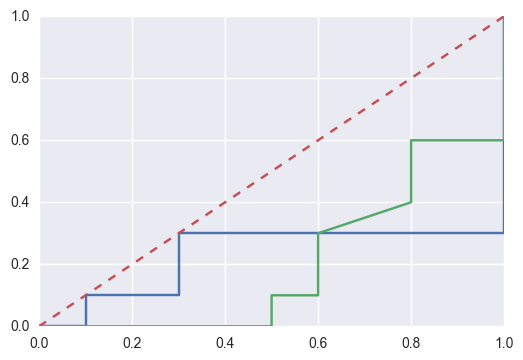

In [154]:
# Curva ROC con promedio y STD para la entropia intra-electrodo
labels = [1] * 10 + [0] * 10
values = np.concatenate((entropias_group_mean[1], entropias_group_mean[0]))
values_std = np.concatenate((entropias_group_std[1], entropias_group_std[0]))
fpr, tpr, a = sklearn.metrics.roc_curve(labels, values)
fpr_std, tpr_std, a_std = sklearn.metrics.roc_curve(labels, values_std)
xs = np.linspace(0, 1, 10)
plt.plot(fpr, tpr)
plt.plot(fpr_std, tpr_std)
plt.plot(xs, xs, linestyle="--")
plt.show()

# Entropia conjunta  Interelectrodo

In [17]:
def calculate_serie(electrodo_matrix, electrodo_serie, min_val, t_bin, cant_bins):
    tam_fila = electrodo_matrix.shape[0] #cant_epochs
    tam_columna = electrodo_matrix.shape[1] #cant_muestras

    vec = np.zeros(cant_bins)
    a = 0
    
    for i in range(0,tam_fila):
        for j in range(0,tam_columna):
            bin_index = int((electrodo_matrix[i][j]-min_val)/t_bin)
            vec[bin_index]=vec[bin_index]+1
            electrodo_serie[i][j] = ord('A')+bin_index
            a=a+1

In [18]:
def probabilidad_conjunta(matrix_serie_1,matrix_serie_2, cant_bins):
    
    mat_PConjunta = np.zeros((cant_bins,cant_bins))

    tam_fila_serie = matrix_serie_1.shape[0]
    tam_columna_serie = matrix_serie_1.shape[1]

    size_serie = tam_fila_serie*tam_columna_serie
    
    for i in range(0,tam_fila_serie):
        for j in range(0,tam_columna_serie):
            index_f = int(matrix_serie_1[i][j]-ord('A'))
            index_c = int(matrix_serie_2[i][j]-ord('A'))
            mat_PConjunta[index_f][index_c]=mat_PConjunta[index_f][index_c]+1
            
    for i in range(0,cant_bins):
        for j in range(0,cant_bins):
            mat_PConjunta[i][j]=mat_PConjunta[i][j]/size_serie
            
    return mat_PConjunta

In [19]:
def calculate_entropia_conjunta(matrix_serie_1,matrix_serie_2,cant_bins):

    mat_PConjunta = probabilidad_conjunta(matrix_serie_1,matrix_serie_2,cant_bins)
    
    res=0
    for h in range(0,mat_PConjunta.shape[0]):
        for k in range(0,mat_PConjunta.shape[1]):
            if(mat_PConjunta[h][k]!=0):
                res=res+(mat_PConjunta[h][k])*math.log(mat_PConjunta[h][k])
    return -res

In [20]:
# se realizò un recorte de los 256 electrodos para el càlculo de la entropìa interelectrodo. 
# Se seleccionaron cuatro cluster correspondientes a la regiòn pre-frontal, debido a su relevancìa en el estudio de 
# diferenceias entre poblaciones con alteraciones de consciencia (King et al., xxx)
electrodes_grupo_1 = [31, 32, 35]
electrodes_grupo_2 = [33, 26, 19, 27, 21, 20]
electrodes_grupo_3 = [34, 28, 29, 22]
electrodes_grupo_4 = [12, 13, 14, 4, 5]

In [21]:
electrode_groups = [electrodes_grupo_1, electrodes_grupo_2, electrodes_grupo_3, electrodes_grupo_4]

In [22]:
p01 = sio.loadmat("/Users/lmatayoshi/Desktop/EEG/S01.mat")
matrix_p01 = p01['data']
#epoch x electrodos x muestras

#Shapes
cant_epochs = matrix_p01.shape[0]
cant_electrodos = matrix_p01.shape[1]
cant_muestras = matrix_p01.shape[2]

#Bins
max_value, min_value, x75, x25 = calculate_bin_max_min(matrix_p01)
t_bin = calculate_tbin(max_value, min_value, x75, x25, matrix_p01.shape)
cant_bins = int((max_value-min_value)/t_bin)+1

#Matrices
array_electrodos_matrix = []
array_electrodos_serie = []

for g in electrode_groups:
    array_electrodos_matrix.append(np.mean(matrix_p01[:, g, :], axis=1))

for i in range(0,len(electrode_groups)):
    array_electrodos_serie.append(np.zeros((cant_epochs, cant_muestras)))

#calculamos las series
for i in range(0,len(electrode_groups)):
    calculate_serie(array_electrodos_matrix[i],array_electrodos_serie[i], min_value, t_bin, cant_bins)

#electrodos tomados de a 2
electrodos_tomados_de_a_2 = list(itertools.combinations(range(0,len(electrode_groups)), 2))
electrodos_tomados_de_a_2 = [list(e) for e in electrodos_tomados_de_a_2]

# El calculo de la entropia conjunta para la combinatoria tarda bastante en ejecutarse (5-10 min)
array_entropia_conjunta = []
for par in electrodos_tomados_de_a_2:
    array_entropia_conjunta.append(calculate_entropia_conjunta(array_electrodos_serie[par[0]],array_electrodos_serie[par[1]],cant_bins))

array_entropia_conjunta_P = np.copy(array_entropia_conjunta)

In [113]:
entropia_conjunta_mean_P = [
    8.88586848583,
    8.65413612925,
    8.78117154693,
    9.3492405686,
    8.67933809549,
    9.11941950404,
    8.91359472144,
    9.0386464701,
    8.10123432253,
    8.83650914978
]

entropia_conjunta_mean_S = [
    8.12147605043,
    7.26826102141,
    8.54137842366,
    8.5153131522,
    8.20354011649,
    8.05144226961,
    8.62693780823,
    8.37295069848,
    8.57618979548,
    8.64700389018
]
entropia_conjunta_mean = np.array(entropia_conjunta_mean_S + entropia_conjunta_mean_P)

In [118]:
entropia_conjunta_std_P = [
    0.193741863889,
    0.219379895889,
    0.287414914788,
    0.152947435212,
    0.406198111093,
    0.192747024669,
    0.217592507868,
    0.283456520592,
    0.147790599355,
    0.182857156466
]

entropia_conjunta_std_S = [
    0.408182971943,
    0.221059202073,
    0.206236358566,
    0.172495249745,
    0.196259683607,
    0.103636808734,
    0.135664770592,
    0.237231956055,
    0.215413931689,
    0.139311006346
]
entropia_conjunta_std = np.array(entropia_conjunta_std_S + entropia_conjunta_std_P)

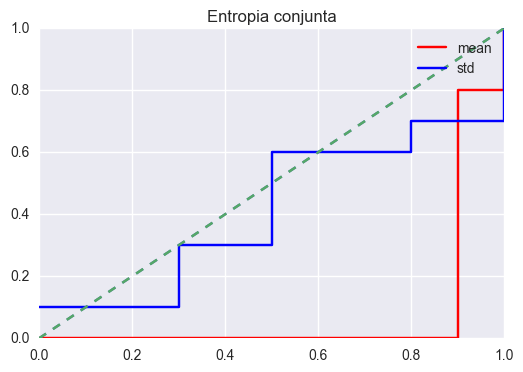

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [127]:
curva_roc_unificada(labels, entropia_conjunta_mean, entropia_conjunta_std, "Entropia conjunta")
labels

# Analisis Univariado

In [255]:
def curva_roc(labels, feature_values, label):
    if label=="mean":
        color = "red"
    else:
        color = "blue"
    feature_values = feature_values.reshape(-1, 1) #Se escalaron los valores, debido a que los Pxx en las bandas eran 
    scaler = StandardScaler()                      # demasiados pequeños.
    feature_values =  scaler.fit_transform(feature_values)
    fpr, tpr, a = sklearn.metrics.roc_curve(labels, feature_values)
    roc_area = auc(fpr, tpr)
    #print feature_values
    plt.plot(fpr, tpr, label=label, color=color)
    xs = np.linspace(0, 1, 10)
    
    plt.plot(xs, xs, linestyle="--", label = 'ROC curve (area = %0.2f)' % roc_area)
    plt.legend()

def curva_roc_unificada(labels, feature_mean , feature_std , title):
    curva_roc(labels, feature_mean, "mean")
    curva_roc(labels, feature_std, "std")
    plt.title(str(title))
    plt.show()
    
#def curva_roc_logistic(labels, logistic_regression):
#    curva_roc(labels, logistic_regression)
#    plt.show()

In [80]:
# frecuencias_mean_S, frecuencias_std_S, frecuencias_mean_P, frecuencias_std_P

In [99]:
labels = [1] * 10 + [0] * 10

In [102]:
frecuencias_mean_S = np.array(frecuencias_mean_S)
frecuencias_mean_P = np.array(frecuencias_mean_P)
frecuencias_std_S = np.array(frecuencias_std_S)
frecuencias_std_P = np.array(frecuencias_std_P)
frecuencias_mean_S_normalizada = np.array(frecuencias_mean_S_normalizadas)
frecuencias_mean_P_normalizada = np.array(frecuencias_mean_P_normalizadas)
frecuencias_std_S_normalizada = np.array(frecuencias_std_S_normalizadas)
frecuencias_std_P_normalizada = np.array(frecuencias_std_P_normalizadas)

### Graficamos las curvas ROC para todos los features

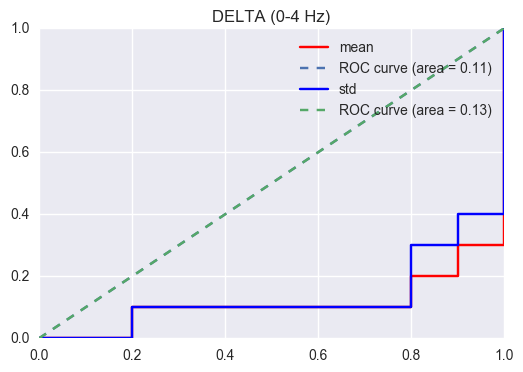

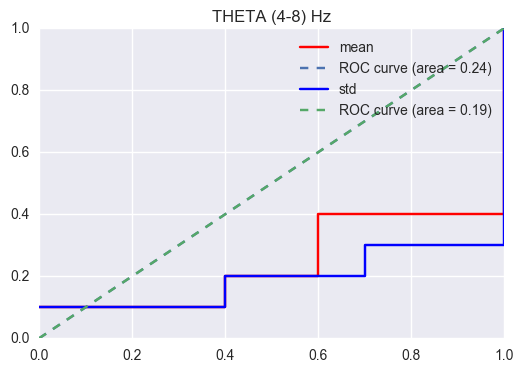

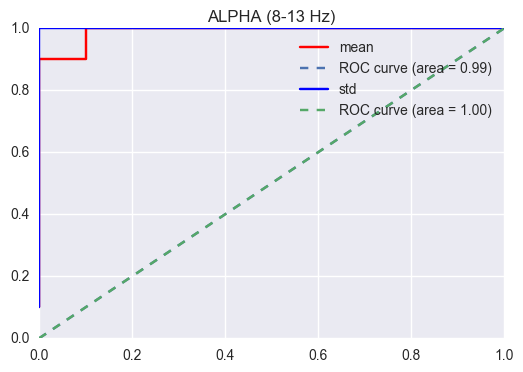

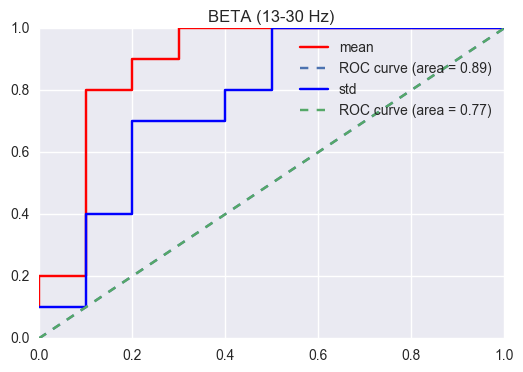

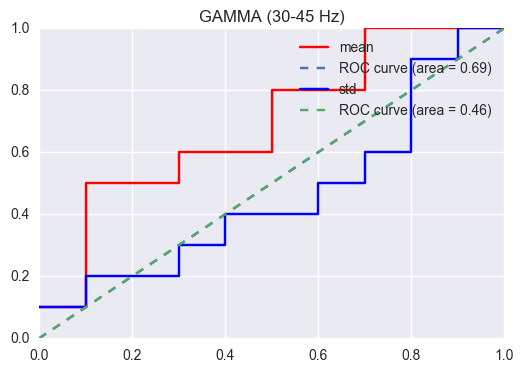

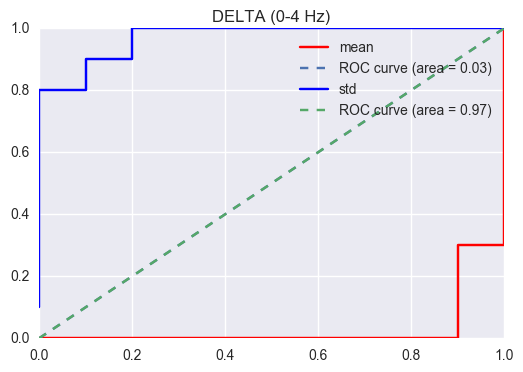

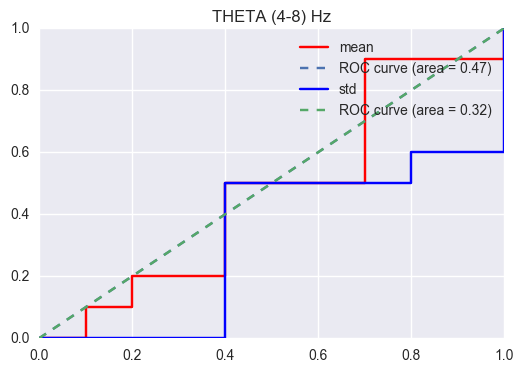

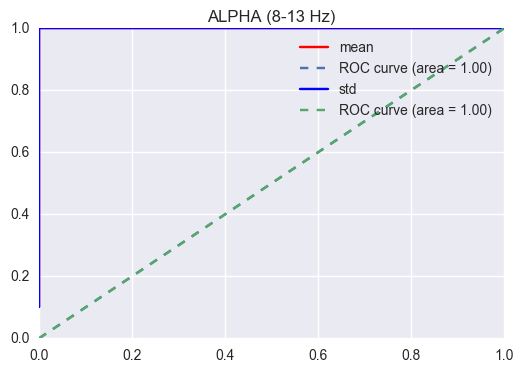

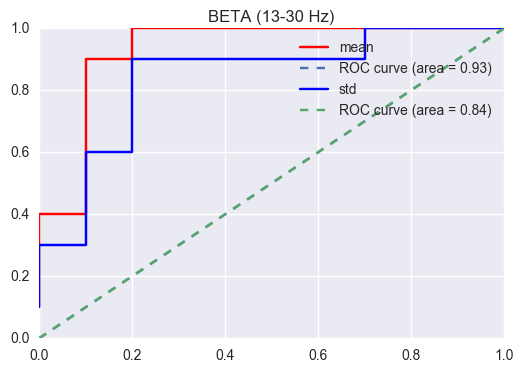

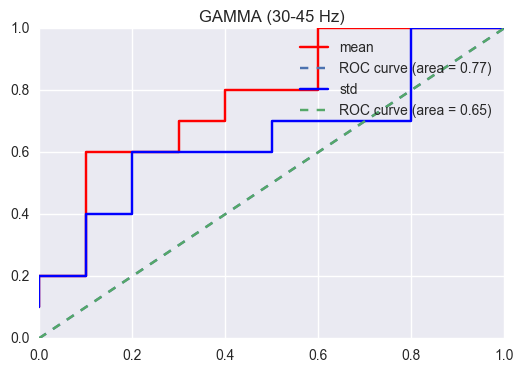

In [256]:
# curva roc DELTA = (0,4)
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,0], frecuencias_mean_P[:,0])),np.concatenate((frecuencias_std_S[:,0], frecuencias_std_P[:,0])),"DELTA (0-4 Hz)")
# curva roc THETA = (4,8)
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,1], frecuencias_mean_P[:,1])), np.concatenate((frecuencias_std_S[:,1], frecuencias_std_P[:,1])),"THETA (4-8) Hz")
# curva roc ALPHA = (8,13)
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,2], frecuencias_mean_P[:,2])), np.concatenate((frecuencias_std_S[:,2], frecuencias_std_P[:,2])),"ALPHA (8-13 Hz)")
# curva roc BETA = (13,30)
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,3], frecuencias_mean_P[:,3])), np.concatenate((frecuencias_std_S[:,3], frecuencias_std_P[:,3])),"BETA (13-30 Hz)")
# curva roc GAMMA = (30,45) 
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,4], frecuencias_mean_P[:,4])), np.concatenate((frecuencias_std_S[:,4], frecuencias_std_P[:,4])),"GAMMA (30-45 Hz)")

#NORM
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,0], frecuencias_mean_P_normalizada[:,0])), np.concatenate((frecuencias_std_S_normalizada[:,0], frecuencias_std_P_normalizada[:,0])),"DELTA (0-4 Hz)")
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,1], frecuencias_mean_P_normalizada[:,1])), np.concatenate((frecuencias_std_S_normalizada[:,1], frecuencias_std_P_normalizada[:,1])),"THETA (4-8) Hz")
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,2], frecuencias_mean_P_normalizada[:,2])), np.concatenate((frecuencias_std_S_normalizada[:,2], frecuencias_std_P_normalizada[:,2])),"ALPHA (8-13 Hz)")
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,3], frecuencias_mean_P_normalizada[:,3])), np.concatenate((frecuencias_std_S_normalizada[:,3], frecuencias_std_P_normalizada[:,3])),"BETA (13-30 Hz)")
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,4], frecuencias_mean_P_normalizada[:,4])), np.concatenate((frecuencias_std_S_normalizada[:,4], frecuencias_std_P_normalizada[:,4])),"GAMMA (30-45 Hz)")


### Clasificador - Logistic Regression

In [58]:
def logistic_regresion_f(frec_mean_S,frec_mean_P):
    training_instances = np.concatenate((frec_mean_S, frec_mean_P))
    training_instances = training_instances.reshape(-1, 1) #Se escalaron los valores, debido a que los Pxx en las bandas eran 
    scaler = StandardScaler()                      # demasiados pequeños.
    training_instances =  scaler.fit_transform(training_instances)
    logistic = linear_model.LogisticRegression()
    labels = [1] * 7 + [0] * 7 
    #test_instances = np.concatenate((frec_mean_S_test, frec_mean_P_test))
    logistic.fit(list(training_instances.reshape(-1,1)), labels)
    return logistic

In [65]:
logistic_mean = []
logistic_std = []
logistic_mean_norm = []
logistic_std_norm = []
for i in range(0,5):
    logistic_mean.append(logistic_regresion_f(frecuencias_mean_S[:7,0],frecuencias_mean_P[:7,i]))
    logistic_std.append(logistic_regresion_f(frecuencias_std_S[:7,i],frecuencias_std_P[:7,i]))
for i in range(0,5):
    logistic_mean_norm.append(logistic_regresion_f(frecuencias_mean_S_normalizada[:7,i],frecuencias_mean_P_normalizada[:7,i]))
    logistic_std_norm.append(logistic_regresion_f(frecuencias_std_S_normalizada[:7,i],frecuencias_std_P_normalizada[:7,i]))

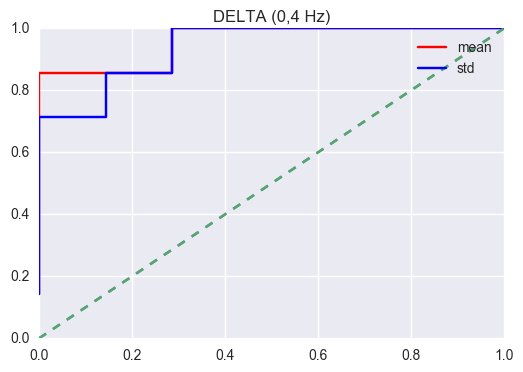

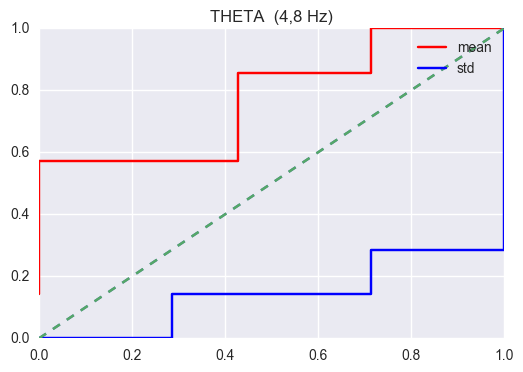

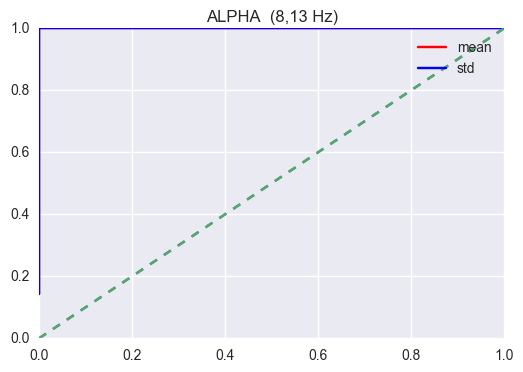

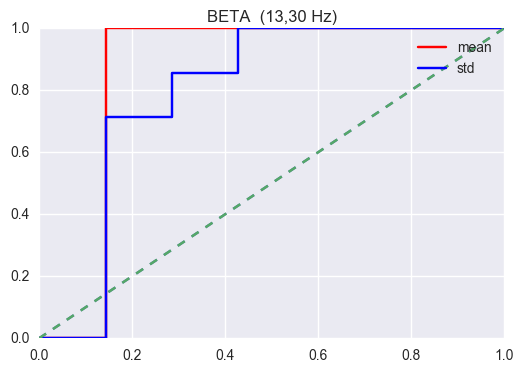

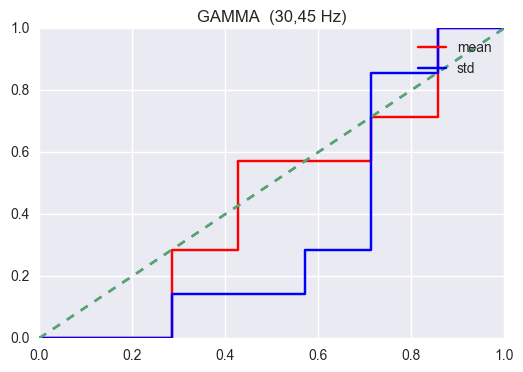

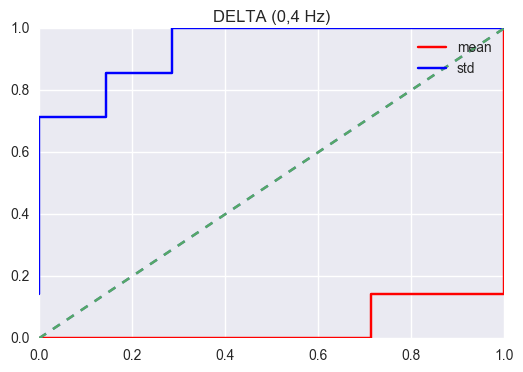

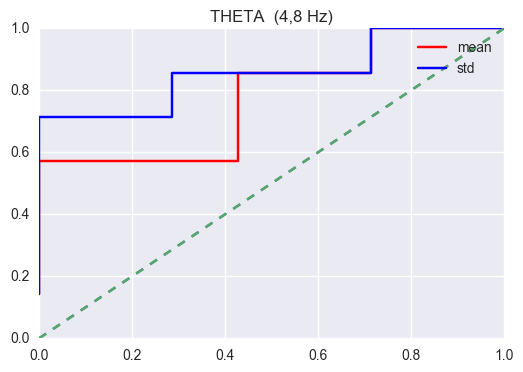

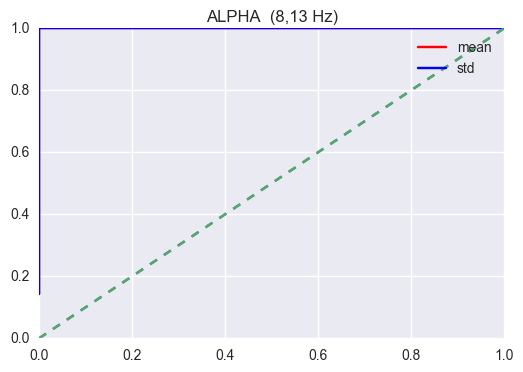

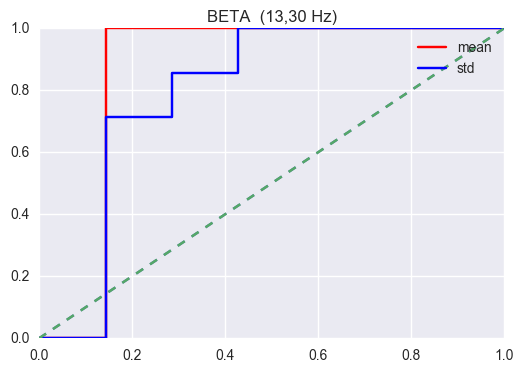

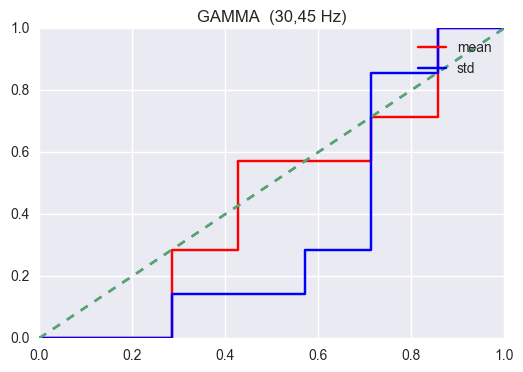

In [112]:
logistic_regresion_graphs(logistic_mean,logistic_std)
logistic_regresion_graphs(logistic_mean_norm,logistic_std_norm)

In [111]:
title = ["DELTA (0,4 Hz)","THETA  (4,8 Hz)","ALPHA  (8,13 Hz)","BETA  (13,30 Hz)","GAMMA  (30,45 Hz)"]
def logistic_regresion_graphs(logistic_std,logistic_mean):
    for i in range(0,5):   
        banda_frec_regression_std = logistic_std[i]
        banda_frec_regression_mean = logistic_mean[i]

        test_instances_std = np.array(np.concatenate((frecuencias_std_S[:7, i], frecuencias_std_P[:7,i])))
        test_instances_std = test_instances_std.reshape(-1,1)
        test_instances_mean = np.array(np.concatenate((frecuencias_mean_S[:7, i], frecuencias_mean_P[:7,i])))
        test_instances_mean = test_instances_mean.reshape(-1,1)

        scaler = StandardScaler() 
        test_instances_std = scaler.fit_transform(test_instances_std)
        test_instances_mean = scaler.fit_transform(test_instances_mean)

        results_std = banda_frec_regression_std.predict_proba(test_instances_std)[:, 1]
        results_mean = banda_frec_regression_mean.predict_proba(test_instances_mean)[:, 1]

        #fpr_std, tpr_std, a_std = sklearn.metrics.roc_curve(labels, results_std)
        #fpr_mean, tpr_mean, a_mean = sklearn.metrics.roc_curve(labels, results_mean)

        curva_roc_unificada( [1] * 7 + [0] * 7, results_mean, results_std,title[i])
        #plt.plot(fpr_std, tpr_std)
        #plt.plot(fpr_mean, tpr_mean)
        #xs = np.linspace(0, 1, 10)
        #plt.plot(xs, xs, linestyle="--")

        plt.show()

## Análisis Multivariado

Los features estaran ordenados: Delta a Gamma Mean, Delta a Gamma Mean Normalized, Delta a Gamma STD,Delta a Gamma STD Normalized, Entropia intra Mean ,Entropia intra STD, Entropia inter Mean, Entropia inter STD

In [278]:
super_array = np.array([
    np.concatenate((frecuencias_mean_S[:,0], frecuencias_mean_P[:,0])),
    np.concatenate((frecuencias_mean_S[:,1], frecuencias_mean_P[:,1])), 
    np.concatenate((frecuencias_mean_S[:,2], frecuencias_mean_P[:,2])), 
    np.concatenate((frecuencias_mean_S[:,3], frecuencias_mean_P[:,3])),  
    np.concatenate((frecuencias_mean_S[:,4], frecuencias_mean_P[:,4])), 

    np.concatenate((frecuencias_mean_S_normalizada[:,0], frecuencias_mean_P_normalizada[:,0])),
    np.concatenate((frecuencias_mean_S_normalizada[:,1], frecuencias_mean_P_normalizada[:,1])),
    np.concatenate((frecuencias_mean_S_normalizada[:,2], frecuencias_mean_P_normalizada[:,2])),
    np.concatenate((frecuencias_mean_S_normalizada[:,3], frecuencias_mean_P_normalizada[:,3])),
    np.concatenate((frecuencias_mean_S_normalizada[:,4], frecuencias_mean_P_normalizada[:,4])), 

    np.concatenate((frecuencias_std_S[:,0], frecuencias_std_P[:,0])),
    np.concatenate((frecuencias_std_S[:,1], frecuencias_std_P[:,1])),
    np.concatenate((frecuencias_std_S[:,2], frecuencias_std_P[:,2])),
    np.concatenate((frecuencias_std_S[:,3], frecuencias_std_P[:,3])),
    np.concatenate((frecuencias_std_S[:,4], frecuencias_std_P[:,4])),
    np.concatenate((frecuencias_std_S_normalizada[:,0], frecuencias_std_P_normalizada[:,0])),
    np.concatenate((frecuencias_std_S_normalizada[:,1], frecuencias_std_P_normalizada[:,1])),
    np.concatenate((frecuencias_std_S_normalizada[:,2], frecuencias_std_P_normalizada[:,2])),
    np.concatenate((frecuencias_std_S_normalizada[:,3], frecuencias_std_P_normalizada[:,3])),
h    np.concatenate((frecuencias_std_S_normalizada[:,4], frecuencias_std_P_normalizada[:,4])),
    ent_gr_mean,
    ent_gr_std,
    entropia_conjunta_mean,
    entropia_conjunta_std  
]
)


In [279]:
super_array.shape

(24, 20)

In [305]:
x1 = super_array[:,0:7]
x2 = super_array[:, 10:17]
training_instances = np.hstack((x1,x2))

In [311]:
test_instances = np.hstack((super_array[:,7:10], super_array[:, 17:20]))
print test_instances.shape

(24, 6)


In [306]:
#Support Vector Machine 
clf = svm.SVC(probability=True)
clf.fit(training_instances.T, [1]*7 + [0]*7) #entrenado con todos 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [312]:
probabilidades=clf.predict_proba(test_instances.T)[:,0]

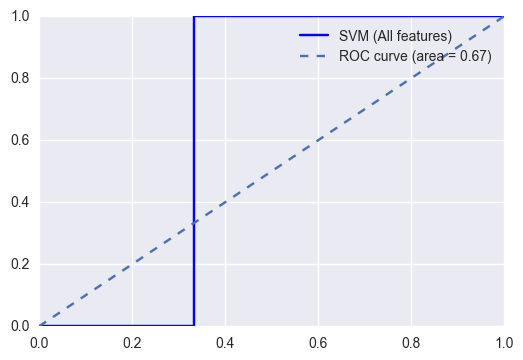

In [314]:
curva_roc([1]*3 + [0]*3, probabilidades, "SVM (All features)")

In [327]:
f_regression(super_array.T, labels)[1] # Realiza un especie de ANOVA y evalua cuàl de todos los features es mejor predicor de los labels
                                       # Devuelve F y p-value de cada feature

array([  1.42396122e-03,   7.58506420e-01,   3.91018034e-04,
         1.60515580e-01,   3.11897008e-01,   8.22057088e-06,
         6.34649016e-01,   1.53785642e-05,   8.48093181e-04,
         8.49669607e-02,   6.05746975e-03,   5.79515280e-01,
         5.00835832e-04,   2.82424905e-01,   5.44350053e-01,
         8.96518786e-05,   1.61240331e-01,   8.76465758e-04,
         2.07563846e-02,   2.23696426e-01,   9.20143540e-02,
         1.76213751e-02,   4.81787516e-03,   5.01515023e-01])

0.85


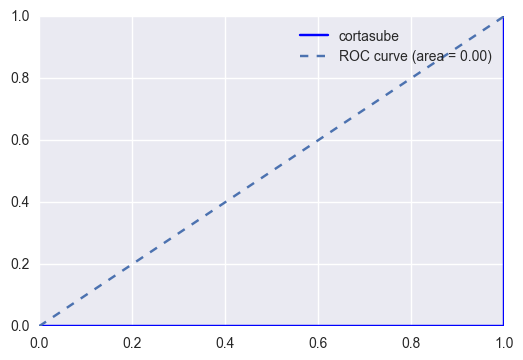

In [404]:
select_k_best_filter = SelectKBest(f_regression, k=2
                                  
                                  ) #10% features
plt.clf()
clf = svm.SVC(kernel='linear', probability=True)
filter_svm = Pipeline([('anova', select_k_best_filter), ('svc', clf)])
filter_svm.fit(super_array.T, labels)
res = filter_svm.predict_proba(super_array.T)
curva_roc(labels, res[:,1], "cortasube")
print filter_svm.score(super_array.T, labels)